In [29]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings('ignore')


# LA dataset addition to SF dataset 

## SF different preproc 

In [3]:
sf_victims = pd.read_csv('sfVictims2011to19.csv', sep = ",")

# Identify and select variables of interest - SF
sf_colms = ['case_id_pkey', 
           'accident_year', 
           'month', 
           'collision_date', 
           'collision_time', 
           'victim_degree_of_injury', 
           'victim_role', 
           'race', 
           'victim_age', 
           'victim_sex', 
           'intersection',
           'party_sobriety']

sf_vars = sf_victims[sf_colms]

# Rename the selected parameters/variables
sf_vars_rename = sf_vars.rename(columns = 
                                {"case_id_pkey": "case_id",
                                 "accident_year": "year",
                                 "month": "month",
                                 "collision_date": "date",
                                 "collision_time": "time",
                                 "victim_degree_of_injury": "injury_severity",
                                 "victim_role": "user",
                                 "race": "race",
                                 "victim_age": "age",
                                 "victim_sex": "gender",
                                 "intersection": "at_intersection",
                                 'party_sobriety': 'DUI'
                                })

sf_vars_rename['city'] = 'sf'

sf_vars_rename.loc[sf_vars_rename['injury_severity'] == 'Complaint of Pain', 'injury_severity'] = 'Complaint of Pain'
sf_vars_rename.loc[sf_vars_rename['injury_severity'] == 'Other Visible Injury', 'injury_severity'] = 'Visible Injury'

# Regroup the values in the column "month"
sf_vars_rename.loc[sf_vars_rename['month'] == 'January', 'month'] = 1
sf_vars_rename.loc[sf_vars_rename['month'] == 'February', 'month'] = 2
sf_vars_rename.loc[sf_vars_rename['month'] == 'March', 'month'] = 3
sf_vars_rename.loc[sf_vars_rename['month'] == 'April', 'month'] = 4
sf_vars_rename.loc[sf_vars_rename['month'] == 'May', 'month'] = 5
sf_vars_rename.loc[sf_vars_rename['month'] == 'June', 'month'] = 6

sf_vars_rename.loc[sf_vars_rename['month'] == 'July', 'month'] = 7
sf_vars_rename.loc[sf_vars_rename['month'] == 'August', 'month'] = 8
sf_vars_rename.loc[sf_vars_rename['month'] == 'September', 'month'] = 9
sf_vars_rename.loc[sf_vars_rename['month'] == 'October', 'month'] = 10
sf_vars_rename.loc[sf_vars_rename['month'] == 'November', 'month'] = 11
sf_vars_rename.loc[sf_vars_rename['month'] == 'December', 'month'] = 12

# Regroup the values in the column "user"
sf_vars_rename.loc[sf_vars_rename['user'] == 'Driver', 'user'] = 'Driver or Passenger'
sf_vars_rename.loc[sf_vars_rename['user'] == 'Passenger', 'user'] = 'Driver or Passenger'
sf_vars_rename.loc[sf_vars_rename['user'] == 'Other', 'user'] = 'Others'

# Replace the invalid values in the "gender" column with NA
sf_vars_rename.gender.replace("Other", np.nan, inplace = True)
sf_vars_rename.gender.replace("Not Stated", np.nan, inplace = True)

# Regroup the values in the column "race"
sf_vars_rename.race.replace("Not Stated", np.nan, inplace = True)
sf_vars_rename.loc[sf_vars_rename['race'] == 'Other', 'race'] = 'Others'

# Regroup the values in the column "DUI"
sf_vars_rename.DUI.replace("Not Stated", np.nan, inplace = True)
sf_vars_rename.DUI.replace("Impairment Not Known", np.nan, inplace = True)
sf_vars_rename.DUI.replace("Not Applicable", np.nan, inplace = True)

sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Had Not Been Drinking', 'DUI'] = 'No'
sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Had Been Drinking, Under Influence', 'DUI'] = 'Yes'
sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Had Been Drinking, Not Under Influence', 'DUI'] = 'Yes'
sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Had Been Drinking, Impairment Unknown', 'DUI'] = 'Yes'

sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Sleepy/Fatigued', 'DUI'] = 'Yes'
sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Impairment - Physical', 'DUI'] = 'Yes'
sf_vars_rename.loc[sf_vars_rename['DUI'] == 'Under Drug Influence', 'DUI'] = 'Yes'

# Regroup the values in the column "at_intersection"
sf_vars_rename.loc[sf_vars_rename['at_intersection'] == 'Intersection <= 20ft', 'at_intersection'] = 'Yes'
sf_vars_rename.loc[sf_vars_rename['at_intersection'] == 'Intersection Rear End <= 150ft', 'at_intersection'] = 'Yes'
sf_vars_rename.loc[sf_vars_rename['at_intersection'] == 'Midblock > 20ft', 'at_intersection'] = 'No'

# Add population and density, defined as population per square mile, 2010
sf_vars_rename['population_density'] = 17179.1

# Select the data from January 2011 to December 2019
sf_vars_short1 = sf_vars_rename[sf_vars_rename['year'] >= 2013]
sf_vars_short = sf_vars_short1[sf_vars_rename['year'] <= 2019]


## LA preproc

In [4]:
# Import and read the LA data
la_victims = pd.read_csv('laVictims2010toPresent.csv', sep = ",")
# Identify and select variables of interest - LA
la_colms = ['DR.Number', 
           'Year', 
           'Month', 
           'Date.Occurred.New', 
           'Time.Occurred', 
           'Collision.Severity', 
           'Collision.Mode', 
           'Gender', 
           'Race.Ethnicity', 
           'Victim.Age', 
           'At.Intersection',
           'DUI']

la_vars = la_victims[la_colms]
# Rename the selected parameters/variables
la_vars_rename = la_vars.rename(columns = 
                                {"DR.Number": "case_id",
                                 "Year": "year",
                                 "Month": "month",
                                 "Date.Occurred.New": "date",
                                 "Time.Occurred": "time",
                                 "Collision.Severity": "injury_severity",
                                 "Collision.Mode": "user",
                                 "Race.Ethnicity": "race",
                                 "Victim.Age": "age",
                                 "Gender": "gender",
                                 "At.Intersection": "at_intersection"
                                })

la_vars_rename['city'] = 'la'

# Regroup the values in the column "uer"
la_vars_rename.loc[la_vars_rename['user'] == 'Veh vs Veh', 'user'] = 'Driver or Passenger'
la_vars_rename.loc[la_vars_rename['user'] == 'Veh vs Ped', 'user'] = 'Pedestrian'
la_vars_rename.loc[la_vars_rename['user'] == 'Bicycle', 'user'] = 'Bicyclist'

# Add population and density, defined as population per square mile, 2010
la_vars_rename['population_density'] = 8092.3

# Select the data from January 2011 to December 2019
la_vars_short1 = la_vars_rename[la_vars_rename['year'] >= 2013]
la_vars_short = la_vars_short1[la_vars_rename['year'] <= 2019]


# Combine the ready data from two cities
frames = [sf_vars_short, la_vars_short]
df_test = pd.concat(frames)

df_test.to_csv("df_test.csv")
df = df_test
df.to_csv("df.csv")


# EDA on SF + LA

In [5]:
df_eda = df_test.copy()

# Regroup the values in the column "injury_severity"
df_eda.loc[df_eda['injury_severity'] == 'Complaint of Pain', 'injury_severity'] = 'Minor Injury or Others'
df_eda.loc[df_eda['injury_severity'] == 'Complaint of Injury', 'injury_severity'] = 'Minor Injury or Others'
df_eda.loc[df_eda['injury_severity'] == 'Others', 'injury_severity'] = 'Minor Injury or Others'
df_eda.loc[df_eda['injury_severity'] == 'Visible Injury', 'injury_severity'] = 'Minor Injury or Others'

df_eda.loc[df_eda['injury_severity'] == 'Fatal Injury', 'injury_severity'] = 'Fatality or Severe Injury'
df_eda.loc[df_eda['injury_severity'] == 'Severe Injury', 'injury_severity'] = 'Fatality or Severe Injury'


### Sex variable

In [6]:
df = df_eda.copy()
df_gender = df.groupby(['injury_severity', 'gender']).agg({'case_id': 'sum'})
df_gender = df_gender.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum()))
df_gender = df_gender.rename(columns = {'case_id': 'pct_per_injury'}).reset_index()

df_gender_overall = pd.DataFrame(
    100 * df.gender.value_counts(normalize = True)).reset_index().rename(columns = {'index': 'gender',
                                                                                    'gender': 'pct_per_injury'})

df_gender_overall['injury_severity'] = 'all'
df_gender = pd.concat([df_gender_overall, df_gender], axis = 0)
df_gender.pivot(index = 'injury_severity', columns = 'gender')


pct_per_injury           
gender                            Female       Male
injury_severity                                    
Fatality or Severe Injury      29.412252  70.587748
Minor Injury or Others         39.780477  60.219523
all                            39.481874  60.518126

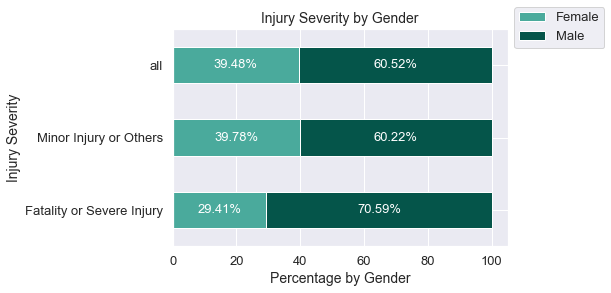

<Figure size 432x288 with 0 Axes>

In [7]:
sns.set_theme()
sns.set(rc = {'figure.figsize': (8, 5)})

cols = ["#4AAA9C", "#05554A"]
s = df_gender.pivot(index = 'injury_severity', 
                    columns = 'gender').plot(kind = 'barh', 
                                             stacked = True, 
                                             color = cols,
                                             fontsize = 13)

leg = plt.legend(loc = 'best', 
                 bbox_to_anchor = (1.0, 0, 0, 1.13), # bbox (x, y, width, height)
                 fontsize = 13)
leg.get_texts()[0].set_text('Female')
leg.get_texts()[1].set_text('Male')

plt.xlabel("Percentage by Gender", fontsize = 14)
plt.ylabel("Injury Severity", fontsize = 14)
plt.title("Injury Severity by Gender", fontsize = 14)

for p in s.patches:
    left, bottom, width, height = p.get_bbox().bounds
    s.annotate("{}%".format(round(width, 2)), 
               xy = (left + width / 2, bottom + height / 2), 
               ha = 'center', 
               va = 'center', 
               color = 'white',
               fontsize = 13)

plt.show()
plt.savefig('gender.png')


##### Age

In [8]:
# Convert the age variable to a categorical one
def get_num_people_by_age_category(df):
    df["age_group"] = pd.cut(x = df['age'], 
                             bins = [0, 17, 34, 64, 199], 
                             labels = ["0-17", "18-34", "35-64", "65+"])
    return df
df = get_num_people_by_age_category(df)

# Barplot for the new age categorical variable
df_age = df.groupby(['injury_severity', 'age_group']).agg({'case_id':'sum'})
df_age = df_age.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum()))
df_age = df_age.rename(columns = {'case_id': 'pct_per_injury'}).reset_index()
df_age_overall = pd.DataFrame(
    100 * df.age_group.value_counts(normalize = True)).reset_index().rename(columns = {'index': 'age_group',
                                                                                       'age_group': 'pct_per_injury'})

df_age_overall['injury_severity'] = 'all'
df_age = pd.concat([df_age_overall, df_age], axis = 0)
df_age.pivot(index = 'injury_severity', columns = 'age_group')

pct_per_injury                                 
age_group                           0-17      18-34      35-64        65+
injury_severity                                                          
Fatality or Severe Injury       1.017350  37.687866  48.025714  13.269070
Minor Injury or Others          0.610585  41.177550  49.857964   8.353901
all                             0.599624  41.003305  49.899868   8.497203

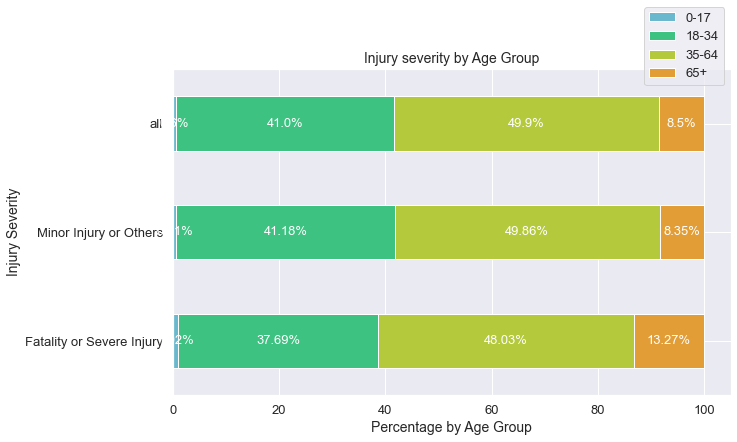

<Figure size 720x432 with 0 Axes>

In [9]:
sns.set_theme()
sns.set(rc = {'figure.figsize': (10, 6)})

cols = ["#6AB8CE", "#3EC281", "#B5C93D", "#E29D36"]
s = df_age.pivot(index = 'injury_severity', columns = 'age_group').plot(kind = 'barh', 
                                                                        stacked = True, 
                                                                        color = cols,
                                                                        fontsize = 13)
leg = plt.legend(loc = 'best', 
                 bbox_to_anchor = (1.0, 0, 0, 1.21), # bbox (x, y, width, height)
                 fontsize = 13)
leg.get_texts()[0].set_text('0-17')
leg.get_texts()[1].set_text('18-34')
leg.get_texts()[2].set_text('35-64')
leg.get_texts()[3].set_text('65+')

plt.xlabel("Percentage by Age Group", fontsize = 14)
plt.ylabel("Injury Severity", fontsize = 14)
plt.title("Injury severity by Age Group", fontsize = 14)

for p in s.patches:
    left, bottom, width, height = p.get_bbox().bounds
    s.annotate("{}%".format(round(width, 2)), 
               xy = (left + width / 2, bottom + height / 2), 
               ha = 'center', 
               va = 'center', 
               color = 'white',
               fontsize = 13)
plt.show()
plt.savefig('age.png')


##### Race

In [10]:
df_race = df.groupby(['injury_severity', 'race']).agg({'case_id': 'sum'})
df_race = df_race.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum()))
df_race = df_race.rename(columns = {'case_id': 'pct_per_injury'}).reset_index()

df_race_overall = pd.DataFrame(
    100 * df.race.value_counts(normalize = True)).reset_index().rename(columns = {'index': 'race',
                                                                                  'race': 'pct_per_injury'})
df_race_overall['injury_severity'] = 'all'
df_race = pd.concat([df_race_overall, df_race], axis = 0)
df_race.pivot(index = 'injury_severity', columns = 'race')


pct_per_injury                                  \
race                               Asian      Black   Hispanic    Others   
injury_severity                                                            
Fatality or Severe Injury       7.134127  17.494686  40.839046  1.579292   
Minor Injury or Others          7.513456  16.565487  45.762168  0.940330   
all                             7.540590  16.539760  45.395575  0.967952   

                                      
race                           White  
injury_severity                       
Fatality or Severe Injury  32.952849  
Minor Injury or Others     29.218559  
all                        29.556123

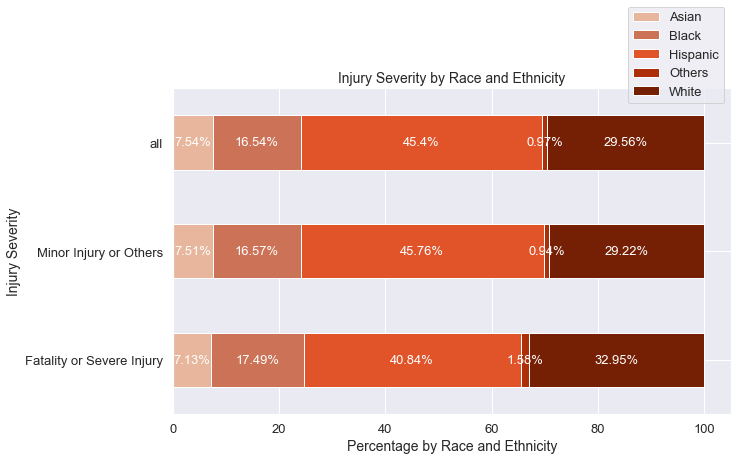

<Figure size 720x432 with 0 Axes>

In [11]:
sns.set_theme()
sns.set(rc = {'figure.figsize': (10, 6)})

cols = ["#E7B69C", "#CC7257", "#E15429", "#AD2F09", '#751F05']
s = df_race.pivot(index = 'injury_severity', 
                  columns = 'race').plot(kind = 'barh', 
                                         stacked = True, 
                                         color = cols,
                                         fontsize = 13)
leg = plt.legend(loc = 'best', 
                 bbox_to_anchor = (1.0, 0, 0, 1.27), # bbox (x, y, width, height)
                 fontsize = 13)
leg.get_texts()[0].set_text('Asian')
leg.get_texts()[1].set_text('Black')
leg.get_texts()[2].set_text('Hispanic')
leg.get_texts()[3].set_text('Others')
leg.get_texts()[4].set_text('White')

plt.xlabel("Percentage by Race and Ethnicity", fontsize = 14)
plt.ylabel("Injury Severity", fontsize = 14)
plt.title("Injury Severity by Race and Ethnicity", fontsize = 14)

for p in s.patches:
    left, bottom, width, height = p.get_bbox().bounds
    s.annotate("{}%".format(round(width, 2)), 
               xy = (left + width / 2, bottom + height / 2),
               ha = 'center', 
               va = 'center', 
               color = 'white',
               fontsize = 13)
plt.show()
plt.savefig('race.png')


##### User type

In [12]:
df_user = df.groupby(['injury_severity', 'user']).agg({'case_id':'sum'})
df_user = df_user.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum()))
df_user = df_user.rename(columns = {'case_id': 'pct_per_injury'}).reset_index()

df_user_overall = pd.DataFrame(
    100 * df.user.value_counts(normalize = True)).reset_index().rename(columns = {'index': 'user',
                                                                                  'user': 'pct_per_injury'})
df_user_overall['injury_severity'] = 'all'
df_user = pd.concat([df_user_overall, df_user], axis = 0)
df_user.pivot(index = 'injury_severity', columns = 'user')


pct_per_injury                                 \
user                           Bicyclist Driver or Passenger     Others   
injury_severity                                                           
Fatality or Severe Injury      10.351596           30.560484  20.883905   
Minor Injury or Others          4.238391           76.601073  12.445194   
all                             4.504621           75.173288  12.681681   

                                      
user                      Pedestrian  
injury_severity                       
Fatality or Severe Injury  38.204016  
Minor Injury or Others      6.715342  
all                         7.640409

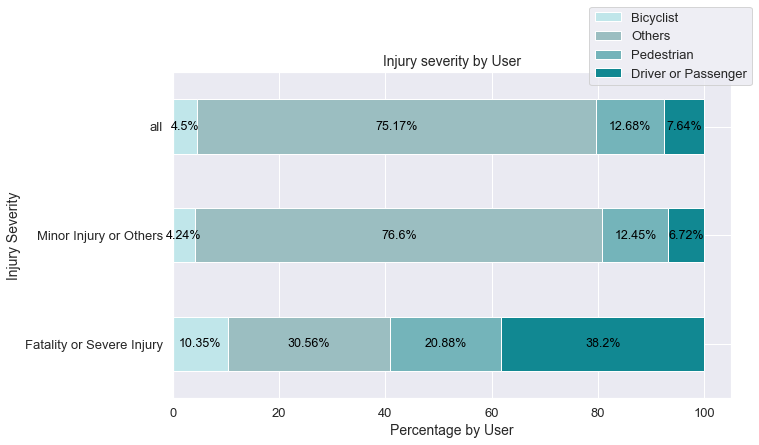

<Figure size 720x432 with 0 Axes>

In [13]:
sns.set_theme()
sns.set(rc = {'figure.figsize': (10, 6)})

cols = ["#C0E6EA", "#9BBEC1", "#74B4BA", "#118892"]
s = df_user.pivot(index = 'injury_severity', 
                  columns = 'user').plot(kind = 'barh', 
                                         stacked = True, 
                                         color = cols,
                                         fontsize = 13)

leg = plt.legend(loc = 'best', 
                 bbox_to_anchor = (1.05, 0, 0, 1.22), # bbox (x, y, width, height)
                 fontsize = 13)
leg.get_texts()[0].set_text('Bicyclist')
leg.get_texts()[1].set_text('Others')
leg.get_texts()[2].set_text('Pedestrian')
leg.get_texts()[3].set_text('Driver or Passenger')

plt.xlabel("Percentage by User", fontsize = 14)
plt.ylabel("Injury Severity", fontsize = 14)
plt.title("Injury severity by User", fontsize = 14)

for p in s.patches:
    left, bottom, width, height = p.get_bbox().bounds
    s.annotate("{}%".format(round(width, 2)), 
               xy = (left + width / 2, bottom + height / 2),
               ha = 'center', 
                va = 'center', 
               color = 'black',
               fontsize = 12.5)
plt.show()
plt.savefig('user.png')


### SARIMA Modelling

In [141]:
df_ts = df
df_ts['day'] = 1
df_ts['date_ts'] = pd.to_datetime(df[["year", "month", "day"]])

# Regroup the values in the column "injury_severity"
df_ts.loc[df_ts['injury_severity'] == 'Fatal Injury', 'injury_severity'] = 'Fatality or Severe Injury'
df_ts.loc[df_ts['injury_severity'] == 'Severe Injury', 'injury_severity'] = 'Fatality or Severe Injury'
df_ts_fatal = df_ts[df_ts["injury_severity"].isin(["Fatality or Severe Injury"])]
df_ts_ka = df_ts[df_ts["injury_severity"].isin(["Fatality or Severe Injury"])]
df_ts_ka_group = df_ts_ka.groupby("date_ts", as_index = False)["injury_severity"].count()




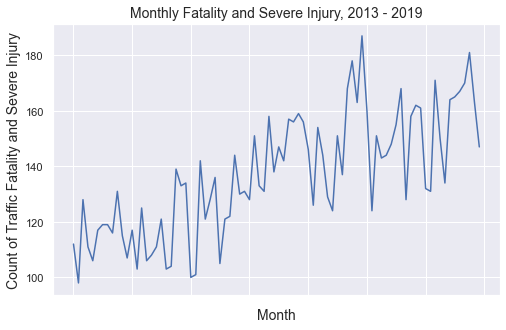

<Figure size 576x360 with 0 Axes>

In [142]:
# Define x and y for plotting the observation data
x = df_ts_ka_group.date_ts
y = df_ts_ka_group.injury_severity

sns.set_theme()
sns.set(rc = {'figure.figsize': (8, 5)})

plt.plot(x, y)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Count of Traffic Fatality and Severe Injury", fontsize = 14)
plt.title("Monthly Fatality and Severe Injury, 2013 - 2019", fontsize = 14)

# Hide the values for x-axis
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.show()
plt.savefig('df_ts.png')

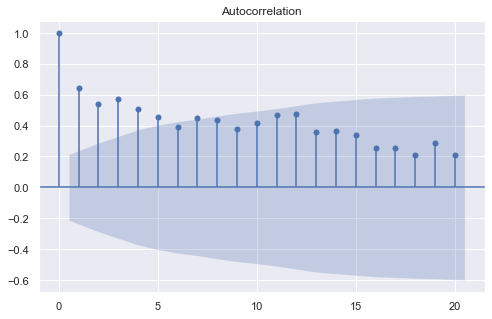

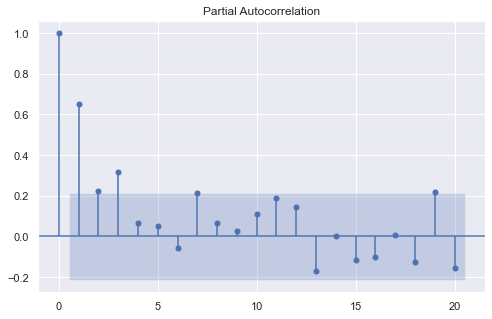

<Figure size 576x360 with 0 Axes>

In [151]:
# Detect stationarity
# Plot ACF - Check the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_ts_ka_group.injury_severity);

# Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_ts_ka_group.injury_severity)

plt.show()
plt.savefig('acf_pacf.png')

Comments:

The data does not meet the stationarity assumption.

From the autocorrelation graph, we can decide if the differencing is needed. If collectively the autocorrelations, or the data point of each lag (in the horizontal axis), are positive for several consecutive lags, more differencing might be needed. Conversely, if more data points are negative, the series is over-differenced.


Comments:

However, a more mathematical test can be employed to determine which order is best for the data in question. The Augmented Dickey-Fuller test is one such measure that statsmodel readily provides. The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

As shown, after the 1st order differencing, the p-value drops beyond the acceptable threshold. Thus, we can consider the order of differencing (“d”) as 1.

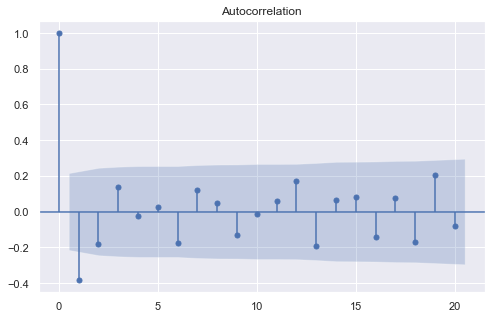

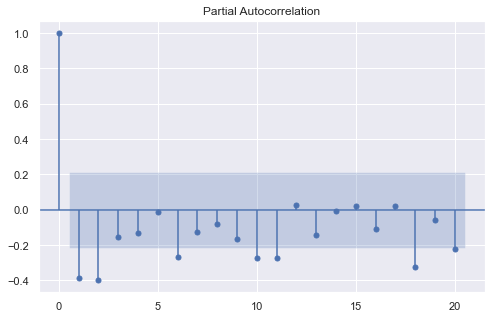

<Figure size 576x360 with 0 Axes>

In [152]:
# Take 1st differencing to obtain stationarity
# Differencing
df_ts_ka_group_diff = df_ts_ka_group.injury_severity.diff().dropna()

# Plot ACF
plot_acf(df_ts_ka_group_diff)

# Plot PACF
plot_pacf(df_ts_ka_group_diff)

plt.show()
plt.savefig('acf_pacf_diff.png')

Comments:

For the non-seasonal part (p, d, q), with the 1st differencing, the data meets stationarity. Thus, d = 1. In the PACF plot, the lag1 presents a significant spike, similarly with the lag2 and lag3. Thus, p = 1, with the alternatives 2, or 3. In the ACF plot, the lag1 presents a significant spike. Thus, q = 1. Thus, we consider the following combinations of parameter candidates (1, 1, 1), (3, 1, 1), or (2, 1, 1).

Notes: 1) PACF shows over-differencing?

In [153]:
# Fit the ARIMA model
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Define the parameters (p = 1, d = 1, q = 1)
arima_model = sm.tsa.arima.ARIMA(df_ts_ka_group.injury_severity, order = (0, 1, 1))
model1 = arima_model.fit()

print(model1.summary()) # The goal is to reach a smaller value of AIC.

                               SARIMAX Results                                
Dep. Variable:        injury_severity   No. Observations:                   84
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -342.471
Date:                Sun, 05 Jun 2022   AIC                            688.942
Time:                        21:59:37   BIC                            693.780
Sample:                             0   HQIC                           690.886
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7806      0.066    -11.905      0.000      -0.909      -0.652
sigma2       222.1050     39.787      5.582      0.000     144.123     300.087
Ljung-Box (L1) (Q):                   0.15   Jarque-

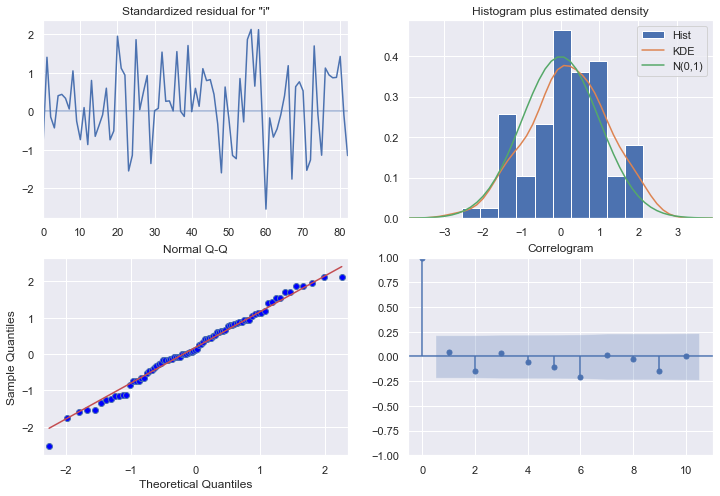

<Figure size 576x360 with 0 Axes>

In [154]:
# Diagnostic measures - ARIMA
# <- Goal: See the residuals to be white noise process.
model1.plot_diagnostics(figsize = (12, 8))

plt.show()
plt.savefig('model1.png')

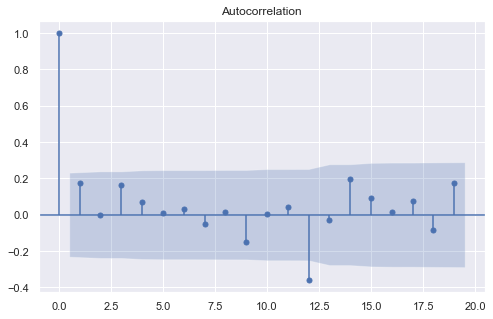

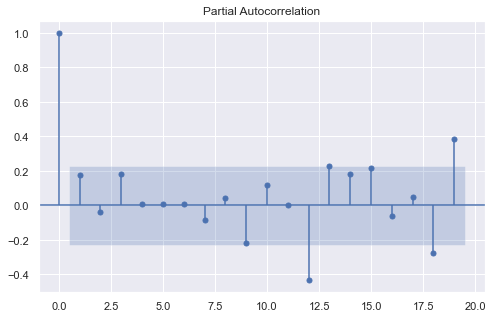

<Figure size 576x360 with 0 Axes>

In [155]:
# Seasonal differencing
df_ts_ka_group_diff_s = df_ts_ka_group.injury_severity.diff(12).dropna()

# Plot ACF
plot_acf(df_ts_ka_group_diff_s)

# Plot PACF
plot_pacf(df_ts_ka_group_diff_s)

plt.show()
plt.savefig('acf_pacf_diff_s.png')

Comments:

Similarly, in the seasonal portion (P, D, Q)m, the first spikes in both the PACF plot and the ACF plot show at the lag12. Thus, the combinations of parameter candidates could be (1, 1, 1, 12).


In [156]:
# Fit SARIMA model
import statsmodels.api as sm

# Use the model (p = 0, d = 1, q = 1), (P = 0, D = 1, Q = 1, m = 12)
# <- Returns the smallest AIC value
sarima_model = sm.tsa.statespace.SARIMAX(df_ts_ka_group.injury_severity,
                                         order = (0, 1, 1),
                                         seasonal_order = (1, 1, 0, 12)) # Maybe (1, 1, 1, 12)

model2 = sarima_model.fit()
print(model2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     injury_severity   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -301.211
Date:                             Sun, 05 Jun 2022   AIC                            608.423
Time:                                     21:59:44   BIC                            615.211
Sample:                                          0   HQIC                           611.122
                                              - 84                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8022      0.078    -10.224      0.000      -0.956      -0.648
ar.S.L12      -0.4567      

Comments:

Interpret model results - 

The model summary returns several statistical measures to evaluate the performance of our model: coefs, Akaike Information Critera (AIC), Bayesian Information Criterion (BIC), Hannan-Quinn Information Criterion (HQIC), and P>|z|.

Reduce AIC - 

The AIC is a good measure for testing the goodness of how fit the model is mathematically. The AIC must be as low as possible. To reduce AIC, we can try changing the p, q, and d values or using training techniques like k-cross-validation. Also, the p-value is very important. We want to see the p-value less than .05 to be statistically meaningful.

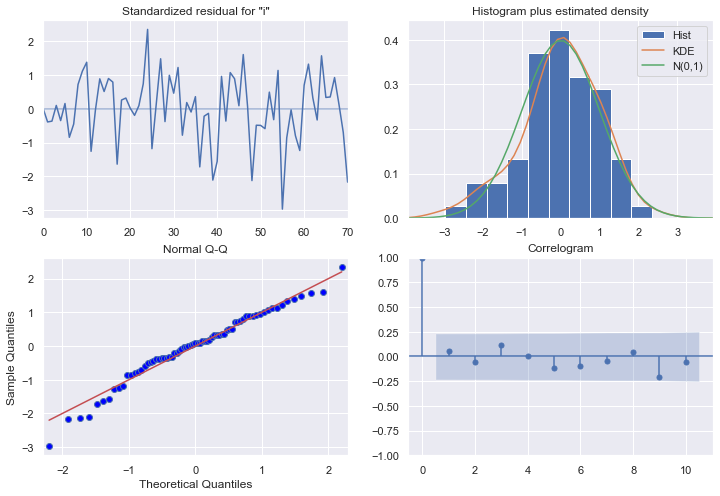

<Figure size 576x360 with 0 Axes>

In [157]:
# Diagnostic measures - SARIMA
# <- Goal: See the residuals to be white noise process.
model2.plot_diagnostics(figsize = (12, 8))

plt.show()
plt.savefig('model2.png')

Interpretation of plots in plot diagnostics:

Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Histogram: The density plot suggest normal distribution with mean slighlty shifted towards left.

Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. The residuals from the final model shows that all autocorrelations are within the threshold limits, indicating that the residuals are behaving like white noise which is what we want to see.

Overall, the model seems to be a good fit.


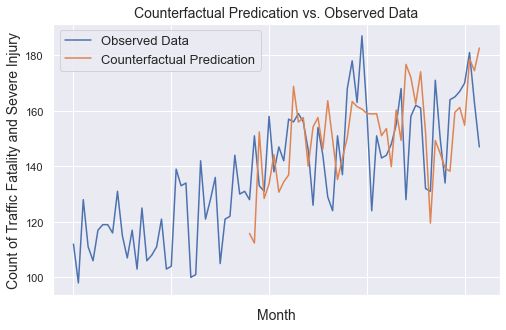

<Figure size 576x360 with 0 Axes>

In [158]:
df_ts_ka_group['forecast'] = model2.predict(start = 36, end = 108, dynamic = False)
# The "dynamic = False argument" ensures that we produce one-step ahead forecasts

df_ts_ka_group[['injury_severity', 'forecast']].plot(figsize = (8, 5))

leg = plt.legend(loc = 'upper left', # bbox (x, y, width, height)
                 fontsize = 13)

leg.get_texts()[0].set_text('Observed Data')
leg.get_texts()[1].set_text('Counterfactual Predication')


plt.xlabel("Month", fontsize = 14)
plt.ylabel("Count of Traffic Fatality and Severe Injury", fontsize = 14)
plt.title("Counterfactual Predication vs. Observed Data", fontsize = 14)

# Hide the values for x-axis
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.show()
plt.savefig('predict.png')

### Classification Algorithms


Comments:

We focus on the classification algorithms. The models that we propose and apply below include: KNN, SVM, Random Forest, Decision Tree, and Logistic Regression.


### Data prep

In [15]:
df_test.head(5)

,case_id,year,month,date,time,injury_severity,user,race,age,gender,at_intersection,DUI,city,population_density
7894,130627378,2013,7,20130730,1240.0,Complaint of Pain,Pedestrian,NaN,44.0,Female,Yes,No,sf,17179.1
7895,130627378,2013,7,20130730,1240.0,Complaint of Pain,Pedestrian,NaN,10.0,Female,Yes,No,sf,17179.1
7896,130592016,2013,7,20130718,1720.0,Complaint of Pain,Driver or Passenger,Hispanic,42.0,Male,Yes,No,sf,17179.1
7897,130592016,2013,7,20130718,1720.0,Complaint of Pain,Driver or Passenger,Hispanic,37.0,Female,Yes,No,sf,17179.1
7898,130592016,2013,7,20130718,1720.0,Visible Injury,Driver or Passenger,Hispanic,10.0,Male,Yes,No,sf,17179.1


In [16]:
df_ml = df_test[df_test['injury_severity'] != 'Others']
df_ml = df_ml.dropna()

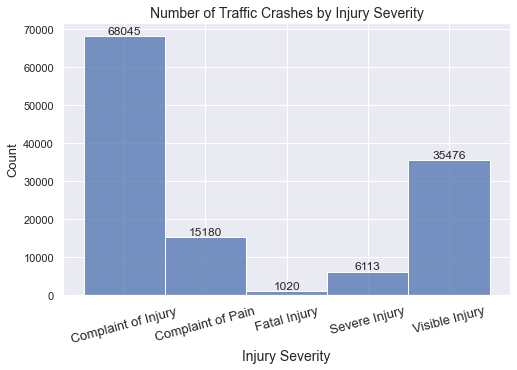

<Figure size 576x360 with 0 Axes>

In [17]:
# Evaluate class imbalance for variables of interest
sns.set_theme()
sns.set(rc={'figure.figsize': (8, 5)})

s = sns.histplot(df_ml.injury_severity.astype('category', copy = False))
plt.xlabel('Injury Severity', fontsize = 14)
plt.xticks(rotation = 15, fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Number of Traffic Crashes by Injury Severity', fontsize = 14)

for p in s.patches:
    s.annotate(f'{p.get_height():}', 
               (p.get_x() + p.get_width() / 2, p.get_height()), 
               ha = 'center', 
               va = 'center', 
               xytext = (0, 5.5), 
               textcoords = 'offset points',
               fontsize = 12)

plt.show()
plt.savefig('count.png')

Comments:

The target variable for casualties is very highly imbalanced with only 0.8% of fatal victims in the entire dataset. However, for the injury severity prediction, it will be a multiclass (4 classes) classification prediction problem, with once again an imbalance issue between each class since the higher the severity of the injury, the less examples we have, but still managable. 

Therefore, we will choose to focus only on the prediction of the severity of injuries of each collision and use only 2 categories of severity injury by combining the 'Fatal' and the 'Injury(Severe)' categories together and the other 2 together.


In [18]:
# Seperate the observed features from the target variable 
X = df_ml.drop(columns = ['injury_severity'])
y = pd.DataFrame(df_ml.injury_severity)

In [19]:
# Convert the categorical variable to numerical with ordered categories 
y.injury_severity = y.injury_severity.map({
    'Fatal Injury': 1,
    'Severe Injury': 1,
    'Visible Injury': 0,
    'Complaint of Injury': 0,
    'Complaint of Pain': 0})

y.injury_severity = y.injury_severity.astype('category')
y.injury_severity.cat.set_categories(new_categories = [0, 1],
                                     ordered = True,
                                     inplace = True)

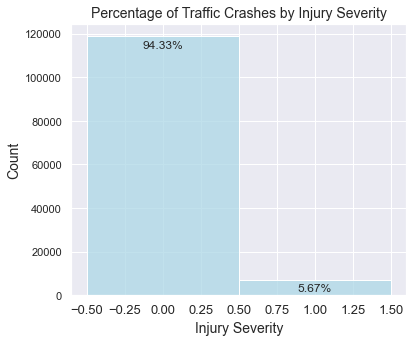

<Figure size 432x360 with 0 Axes>

In [20]:
sns.set_theme()
sns.set(rc={'figure.figsize': (6, 5)})
s1 = sns.histplot(y.injury_severity, color = 'lightblue')

plt.xlabel('Injury Severity', fontsize = 14)
plt.xticks(fontsize = 13)
plt.ylabel("Count", fontsize = 14)
plt.title("Percentage of Traffic Crashes by Injury Severity", fontsize = 14)


for p in s1.patches:
    s1.annotate("{}%".format(round((p.get_height() * 100) / len(df_ml), 2)), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, -9), 
                textcoords = 'offset points',
                fontsize = 12)
plt.show()
plt.savefig('pct.png')

In [21]:
# Drop useless columns 
X = X.drop(columns = ['case_id', 'date', 'time', 'month'])

In [22]:
# First convert object variables in X to categorical
cols_object = X.select_dtypes(['object']).columns

for col in cols_object:
    X[col] = X[col].astype('category')
    
# Then convert the categorical to dummy variables by one-hot encoding
cat_columns = X.select_dtypes(['category']).columns
df1 = pd.get_dummies(X, columns = cat_columns)

# Split for test set and train set
xtrain, xtest, ytrain, ytest = train_test_split(df1, y, test_size = 0.2, random_state = 10, stratify=y)

# Scale the data
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)



## Over-sampling and Under-sampling 

### Might not be necessary afterall with using imblearn.Pipeline for GridsearchCV for imbalanced dataset..

In [23]:
# Combining oversampling and undersampling using a train and validation set
# Since we cannot use CV on an oversampled data -> garantee of overfitting

# Split for test set and train set
xtrain2, xval, ytrain2, yval = train_test_split(xtrain, ytrain, test_size = 0.2, random_state = 10, stratify=ytrain)

# Scale the data
xtrain_scaled2 = scaler.fit_transform(xtrain2)
xtest_scaled2 = scaler.transform(xval)

# For this resampled data, we will use a simple Gridsearch on the X_resampled
# with X_resampled obtained for xtrain2

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
Xover, yover = over.fit_resample(xtrain_scaled2, ytrain2)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.7)
# fit and apply the transform
X_resampled, y_resampled = under.fit_resample(Xover, yover)

## Logistic regression 

### Original data training 

In [175]:
# Gridsearch to tune the Logisitc Regression model on original data 
logr = LogisticRegression()
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3,3,7),
    'class_weight' : ['balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
clf = GridSearchCV(logr,
                  param_grid = parameters,
                  scoring = 'roc_auc',
                  cv = 5, 
                  verbose=5,
                  n_jobs=3)

clf.fit(xtrain, ytrain)
print("Tuned Hyperparameters: {}".format(clf.best_params_))
print("AUC: {}".format(clf.best_score_))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Tuned Hyperparameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
AUC: 0.749508352459016


In [176]:
# Logistic Regression with tune hyperparameter
lr1 = LogisticRegression(C = 0.01,
                       solver='liblinear', 
                       class_weight='balanced',
                       random_state=0,
                       penalty='l1')


lr1.fit(xtrain, ytrain)
y_score1 =  lr1.fit(xtrain, ytrain).decision_function(xtest)


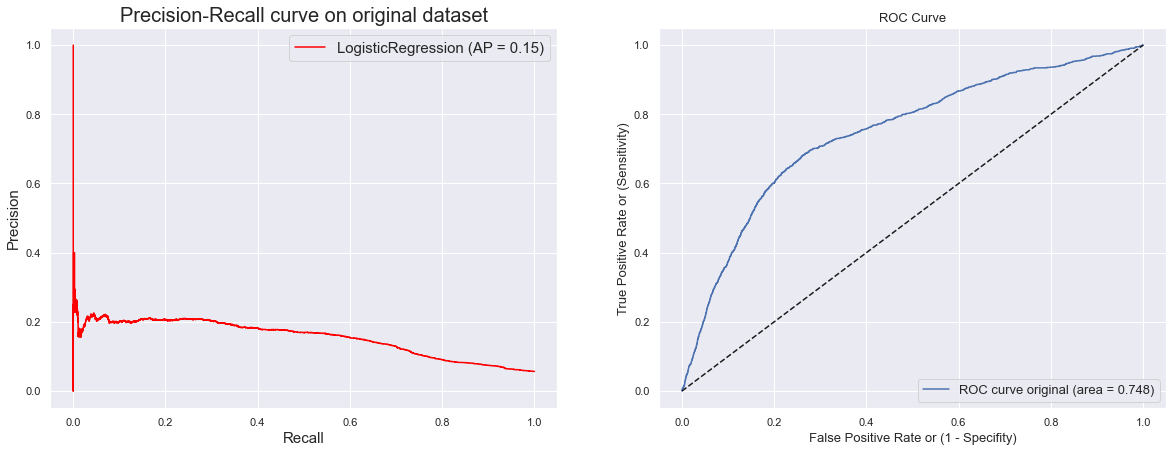

In [177]:
# Compute fpr, tpr, thresholds and roc auc and pr curve
sns.set(rc={'figure.figsize': (10, 7)})

# Plot the PR curve
fig, axes = plt.subplots(1, 2, figsize=(20,7))
plot_precision_recall_curve(lr1, xtest, ytest, color='Red', ax=axes[0])
axes[0].legend(fontsize=15)
axes[0].set_xlabel('Recall', fontsize=15)
axes[0].set_ylabel('Precision', fontsize=15)
axes[0].set_title('Precision-Recall curve on original dataset', fontsize=20)


fpr1, tpr1, thresholds = roc_curve(ytest, y_score1)
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, label='ROC curve original (area = %0.3f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)', fontsize=13)
plt.ylabel('True Positive Rate or (Sensitivity)', fontsize=13)
plt.title('ROC Curve', fontsize=13)
plt.legend(loc="lower right", fontsize=13)

### Find the optimal threshold for LR predictions model 1

Threshold=0.661, F-Score=0.25536


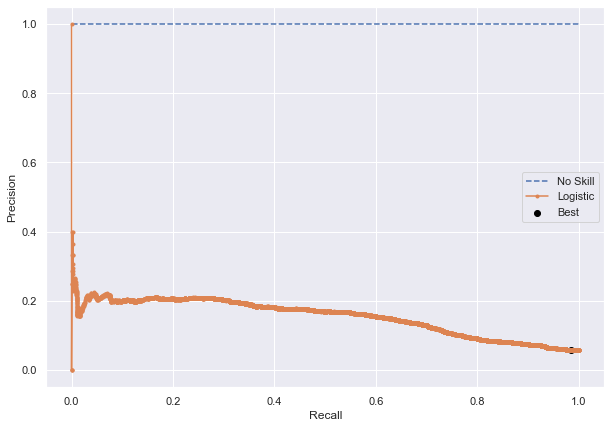

In [178]:
# Trying to find the best threshold for precision-recall curve for original data 
yhat1 = lr1.predict_proba(xtest)
yhat1 = yhat1[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(ytest, yhat1)

# define thresholds
thresholds = np.arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# evaluate each threshold
scores = [f1_score(ytest, to_labels(yhat1, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


In [179]:
## Let's choose the optimal threshold with the highest recall i.e. 0.683

# Print the confusion matrix of each class predictions 
y_pred = lr1.predict(xtest)
print('Confusion matrix for model trained on original dataset: \n\n {}\n'.format(confusion_matrix(ytest, y_pred)))

# Print the precision, recall and F1 score for each class
print('Classification report: \n\n {}'.format(classification_report(ytest, y_pred, target_names=['Class 0', 'Class 1'])))


# y_pred = clf.predict(X_test)  # default threshold is 0.5
y_pred1 = (lr1.predict_proba(xtest)[:,1] >= 0.661).astype(bool) # set threshold 
print("F1 score for original trained data: {}".format(f1_score(ytest, y_pred1)))


Confusion matrix for model trained on original dataset: 

 [[17680  6060]
 [  469   958]]

Classification report: 

               precision    recall  f1-score   support

     Class 0       0.97      0.74      0.84     23740
     Class 1       0.14      0.67      0.23      1427

    accuracy                           0.74     25167
   macro avg       0.56      0.71      0.54     25167
weighted avg       0.93      0.74      0.81     25167

F1 score for original trained data: 0.25248802064135645


## Resampled data training

In [ ]:
# Use the validation for a simple Gridsearch to tune the Logisitc Regression model 

smote_enn = SMOTEENN(random_state=0)

logr = LogisticRegression(random_state=0)
pipeline = Pipeline([('sampling', smote_enn), ('class', logr)])

parameters2 = {
    'class__penalty': ['l1', 'l2'],
    'class__C': [0.001, 0.01, 0.1, 10],
    'class__solver': ['newton-cg', 'lbfgs', 'liblinear']
}


clf_lr = GridSearchCV(pipeline,
                    parameters2,
                    scoring = 'roc_auc',
                    cv=5,
                    verbose=10,
                    n_jobs=-1)

clf_lr.fit(xtrain, ytrain)
print("Tuned Hyperparameters: {}".format(clf_lr.best_params_))
print("AUC: {}".format(clf_lr.best_score_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
# training second model trained on resampled data 
lr2 = LogisticRegression(C = 0.1,
                         solver='liblinear',
                         random_state=0,
                         penalty='l1')


lr2.fit(xtrain, ytrain)
y_score2 =  lr2.fit(xtrain, ytrain).decision_function(xtest)


In [ ]:
# Compute fpr, tpr, thresholds and roc auc and pr curve
sns.set(rc={'figure.figsize': (10, 7)})

# Plot the PR curve
fig, axes = plt.subplots(1, 2, figsize=(20,7))
plot_precision_recall_curve(lr2, xtest, ytest, color='Red', ax=axes[0])
axes[0].legend(fontsize=15)
axes[0].set_xlabel('Recall', fontsize=15)
axes[0].set_ylabel('Precision', fontsize=15)
axes[0].set_title('Precision-Recall curve on original dataset', fontsize=20)


fpr2, tpr2, thresholds = roc_curve(ytest, y_score2)
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr2, tpr2, label='ROC curve original (area = %0.3f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)', fontsize=13)
plt.ylabel('True Positive Rate or (Sensitivity)', fontsize=13)
plt.title('ROC Curve', fontsize=13)
plt.legend(loc="lower right", fontsize=13)

Threshold=0.690, F-Score=0.28300


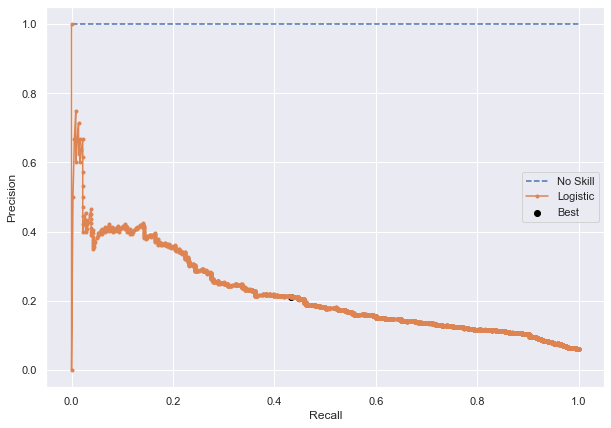

In [108]:
# Trying to find the best threshold for precision-recall curve for balanced data

yhat2 = lr2.predict_proba(xtest)
yhat2 = yhat2[:, 1]


# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(ytest, yhat1)

# evaluate each threshold
scores = [f1_score(ytest, to_labels(yhat2, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


In [ ]:
# Print the confusion matrix of each class predictions 
y_pred = lr2.predict(xtest)
print('Confusion matrix for model trained on balanced dataset: \n\n {}\n'.format(confusion_matrix(ytest, y_pred)))

# Print the precision, recall and F1 score for each class
print('Classification report: \n\n {}'.format(classification_report(ytest, y_pred, target_names=['Class 0', 'Class 1'])))


# y_pred = clf.predict(X_test)  # default threshold is 0.5
y_pred2 = (lr2.predict_proba(xtest)[:,1] >= 0.690).astype(bool) # set threshold 
print("F1 score for balanced trained data: {}".format(f1_score(ytest, y_pred2)))



## Comparison plots

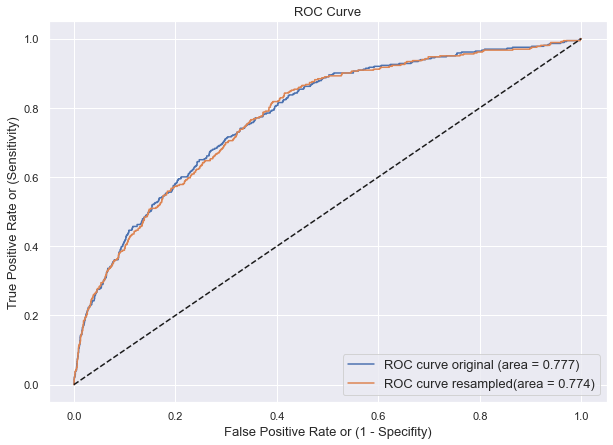

In [103]:
# Compute fpr, tpr, thresholds and roc auc
sns.set(rc={'figure.figsize': (10, 7)})

fpr1, tpr1, thresholds = roc_curve(ytest, y_score1)
fpr2, tpr2, thresholds = roc_curve(ytest, y_score2)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr1, tpr1, label='ROC curve original (area = %0.3f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve resampled(area = %0.3f)' % roc_auc2)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)', fontsize=13)
plt.ylabel('True Positive Rate or (Sensitivity)', fontsize=13)
plt.title('ROC Curve', fontsize=13)
plt.legend(loc="lower right", fontsize=13)

Text(0.5, 1.0, 'Precision-Recall curve on balanced dataset')

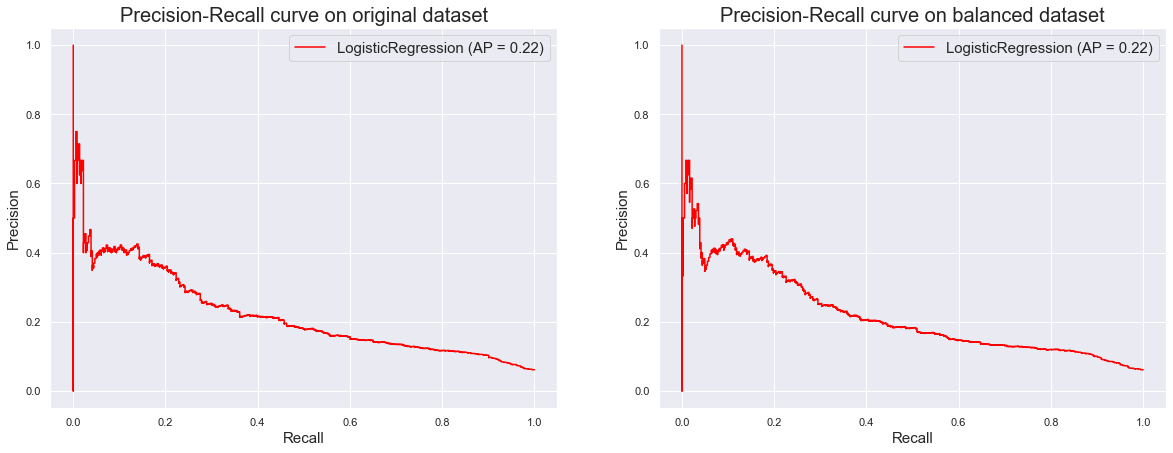

In [104]:
# Plot the PR curve
fig, axes = plt.subplots(1, 2, figsize=(20,7))
plot_precision_recall_curve(lr1, xtest, ytest, color='Red', ax=axes[0])
axes[0].legend(fontsize=15)
axes[0].set_xlabel('Recall', fontsize=15)
axes[0].set_ylabel('Precision', fontsize=15)
axes[0].set_title('Precision-Recall curve on original dataset', fontsize=20)

plot_precision_recall_curve(lr2, xtest, ytest, color='Red', ax=axes[1])
axes[1].legend(fontsize=15)
axes[1].set_xlabel('Recall', fontsize=15)
axes[1].set_ylabel('Precision', fontsize=15)
axes[1].set_title('Precision-Recall curve on balanced dataset', fontsize=20)


## Random Forest Classifier 

In [199]:
# Converting the categorical string variable to numerical, One-hot encoding is not for RandomForest
le = LabelEncoder()
cols_object = X.select_dtypes(['category']).columns
for col in cols_object:
    X[col] = le.fit_transform(X[col])
X

,year,user,race,age,gender,at_intersection,DUI,city,population_density
7896,2013,1,2,42.0,1,1,0,1,17179.1
7897,2013,1,2,37.0,0,1,0,1,17179.1
7898,2013,1,2,10.0,1,1,0,1,17179.1
7900,2013,1,1,18.0,0,0,0,1,17179.1
7902,2013,1,2,42.0,0,1,0,1,17179.1
...,...,...,...,...,...,...,...,...,...
569372,2019,2,2,27.0,1,0,0,0,8092.3
569373,2019,3,2,77.0,1,1,0,0,8092.3
569393,2018,1,2,32.0,1,0,1,0,8092.3
569409,2015,1,2,26.0,0,1,0,0,8092.3


In [214]:
# Combining oversampling and undersampling using a train and validation set
# Since we cannot use CV on an oversampled data -> garantee of overfitting

# Split for test set and train set
xtrain_rf, xtest_rf, ytrain_rf, ytest_rf = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify=y)

# For this resampled data, we will use a simple Gridsearch on the X_resampled
# with X_resampled obtained for xtrain2

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
Xover, yover = over.fit_resample(xtrain_rf, ytrain_rf)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.7)
# fit and apply the transform
X_resampled_rf, y_resampled_rf = under.fit_resample(Xover, yover)

### RFC on original dataset 

In [216]:
# Gridsearch cv hyperparameter tuning with original data 

parameters = {'max_depth': [10, 20, None],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5],
              'n_estimators': [100, 300]}
rfc = RandomForestClassifier() 
grid_rf = GridSearchCV(estimator=rfc, param_grid=parameters, cv= 5, n_jobs=4, scoring='roc_auc', verbose=5)
grid_rf.fit(xtrain_rf, ytrain_rf)
print(grid_rf.best_params_)
print(grid_rf.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
0.754277262319396


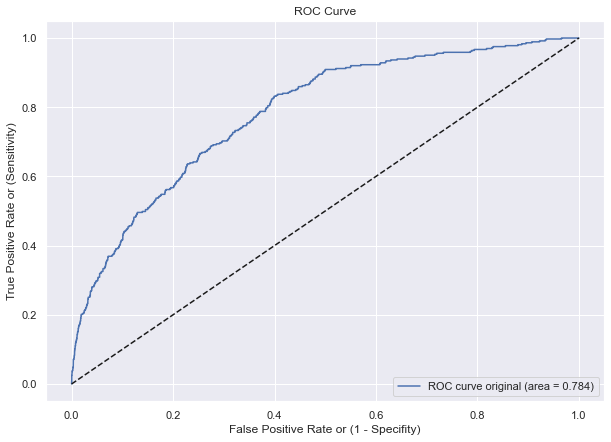

Confusion matrix: 

 [[5543    0]
 [ 363    0]]

Classification report: 

               precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97      5543
     Class 1       0.00      0.00      0.00       363

    accuracy                           0.94      5906
   macro avg       0.47      0.50      0.48      5906
weighted avg       0.88      0.94      0.91      5906

F1 score: 0.0


In [92]:
# RF trained with and without oversampled data
rf1 = RandomForestClassifier(max_depth=100, 
                             min_samples_leaf=8, 
                             min_samples_split=4,
                             n_estimators=300, 
                             random_state=0)
rf1.fit(x_train_rf, y_train_rf)
fpr1, tpr1, thresholds = roc_curve(y_test_rf, rf1.predict_proba(x_test_rf)[:,1])
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='ROC curve original (area = %0.3f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print the confusion matrix of each class predictions 
y_pred = rf1.predict(x_test_rf)
print('Confusion matrix: \n\n {}\n'.format(confusion_matrix(y_test_rf, y_pred)))

# Print the precision, recall and F1 score for each class
print('Classification report: \n\n {}'.format(classification_report(y_test_rf, y_pred, target_names=['Class 0', 'Class 1'])))
print("F1 score: {}".format(f1_score(y_test_rf, y_pred)))



## Random Forest with resampled data

In [212]:
smote_enn = SMOTEENN(random_state=0)

rf = RandomForestClassifier(random_state=88)
pipeline = Pipeline([('sampling', smote_enn), ('class', rf)])

grid = {'class__n_estimators': [100, 300],
        'class__max_features': ['sqrt', 'log2'],
        'class__max_depth' : [10, 20, None],
        'class__min_samples_split': [2, 5]}

clf2 = GridSearchCV(pipeline,
                    grid,
                    scoring = 'roc_auc',
                    cv=5,
                    verbose=10,
                    n_jobs=-1)

clf2.fit(xtrain_rf, ytrain_rf)
print("Tuned Hyperparameters: {}".format(clf2.best_params_))
print("AUC: {}".format(clf2.best_score_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuned Hyperparameters: {'class__max_depth': 10, 'class__max_features': 'sqrt', 'class__min_samples_split': 5, 'class__n_estimators': 300}
AUC: 0.7325905660294298


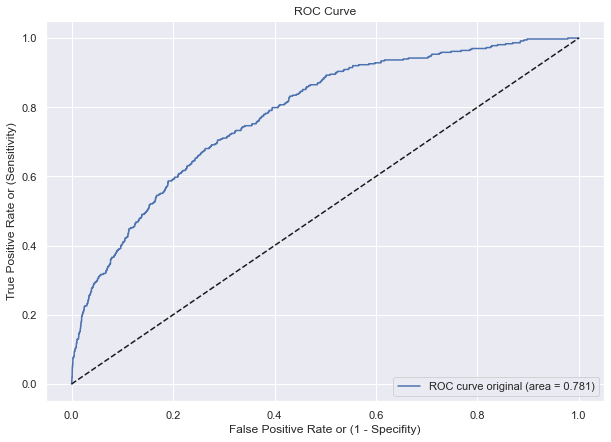

Confusion matrix: 

 [[5393  150]
 [ 281   82]]

Classification report: 

               precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96      5543
     Class 1       0.35      0.23      0.28       363

    accuracy                           0.93      5906
   macro avg       0.65      0.60      0.62      5906
weighted avg       0.91      0.93      0.92      5906

F1 score: 0.2756302521008403


In [110]:
# RF trained with and without oversampled data
rf2 = RandomForestClassifier(max_depth=10, 
                             max_features='sqrt',
                             min_samples_leaf=4, 
                             min_samples_split=5,
                             n_estimators=300, 
                             random_state=0)
rf2.fit(xtrain_rf, ytrain_rf)


fpr2, tpr2, thresholds = roc_curve(y_test_rf, rf2.predict_proba(x_test_rf)[:,1])
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='ROC curve original (area = %0.3f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print the confusion matrix of each class predictions 
y_pred = rf2.predict(x_test_rf)
print('Confusion matrix: \n\n {}\n'.format(confusion_matrix(y_test_rf, y_pred)))

# Print the precision, recall and F1 score for each class
print('Classification report: \n\n {}'.format(classification_report(y_test_rf, y_pred, target_names=['Class 0', 'Class 1'])))
print("F1 score: {}".format(f1_score(y_test_rf, y_pred)))


### AUC curve comparison plot

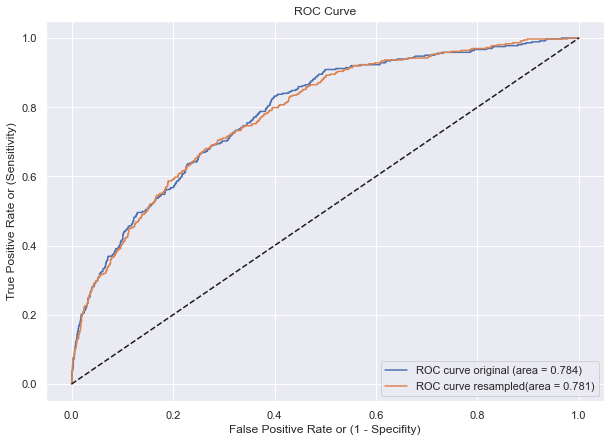

In [101]:
# Compute fpr, tpr, thresholds and roc auc

fpr1, tpr1, thresholds = roc_curve(y_test_rf, rf1.predict_proba(x_test_rf)[:,1])
fpr2, tpr2, thresholds = roc_curve(y_test_rf, rf2.predict_proba(x_test_rf)[:,1])

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr1, tpr1, label='ROC curve original (area = %0.3f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve resampled(area = %0.3f)' % roc_auc2)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# KNN classifier

## Training on original dataset

In [25]:
def classif_report(Ytest, Ypred): 
    
    # Importing confusion matrix
    confusion = confusion_matrix(Ytest, Ypred)
    print('Confusion Matrix\n')
    print(confusion)

    # Importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Ytest, Ypred)))

    print('Micro Precision: {:.2f}'.format(precision_score(Ytest, Ypred, average = 'micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(Ytest, Ypred, average = 'micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(Ytest, Ypred, average = 'micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(Ytest, Ypred, average = 'macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(Ytest, Ypred, average = 'macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(Ytest, Ypred, average = 'macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(Ytest, Ypred, average = 'weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(Ytest, Ypred, average = 'weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(Ytest, Ypred, average = 'weighted')))

    print('\nClassification Report\n')
    print(classification_report(Ytest, Ypred, target_names = ['Class 1', 'Class 2']))

In [ ]:
knn_ = KNeighborsClassifier()
parameters = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 
              'weights': ['uniform','distance']}

knn_clf = GridSearchCV(knn_, 
                       param_grid = parameters, 
                       scoring = 'roc_auc', 
                       cv = 5, 
                       verbose = 5,
                       n_job=5)

knn_clf.fit(xtrain, ytrain)
print("Tuned Hyperparameters: {}".format(knn_clf.best_params_))
print("AUC: {}".format(knn_clf.best_score_))

Confusion Matrix

[[23739     1]
 [ 1427     0]]

Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.47
Macro Recall: 0.50
Macro F1-score: 0.49

Weighted Precision: 0.89
Weighted Recall: 0.94
Weighted F1-score: 0.92

Classification Report

              precision    recall  f1-score   support

     Class 1       0.94      1.00      0.97     23740
     Class 2       0.00      0.00      0.00      1427

    accuracy                           0.94     25167
   macro avg       0.47      0.50      0.49     25167
weighted avg       0.89      0.94      0.92     25167

None


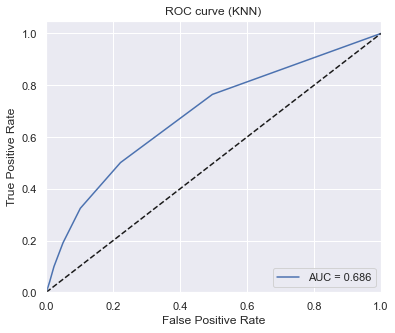

In [26]:
# Fit the KNN model - w/o oversampling , GridSearchCV parameters
knn1 = KNeighborsClassifier(n_neighbors = 19,weights = 'uniform').fit(xtrain, ytrain)

knn_pred = knn1.predict(xtest)

print(classif_report(ytest, knn_pred))

knn_score1 = knn1.predict_proba(xtest)

n_classes = 2
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(n_classes):
    fpr1[i], tpr1[i], _ = roc_curve(ytest, knn_score1[:, i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

# Plot the PR curve
# plot_precision_recall_curve(knn, xtest, ytest, color = 'Red')

# Plot of a ROC curve for a specific class: 1
plt.figure()

plt.plot(fpr1[1], tpr1[1], label = 'AUC = {}'.format(round(roc_auc1[i], 3)))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (KNN)')

plt.legend(loc = "lower right")
plt.show()

## KNN resampled dataset

In [31]:
smote_enn = SMOTEENN(random_state=0)
knn_ = KNeighborsClassifier()

pipeline_knn = Pipeline([('sampling', smote_enn), ('class', knn_)])

grid_knn = {'class__n_neighbors': [7, 13, 17, 19, 30],
        'class__weights': ['uniform','distance']}

clf_knn = GridSearchCV(pipeline_knn,
                    grid_knn,
                    scoring = 'roc_auc',
                    cv=5,
                    verbose=10,
                    n_jobs=-1)

clf_knn.fit(xtrain, ytrain)
print("Tuned Hyperparameters: {}".format(clf_knn.best_params_))
print("AUC: {}".format(clf_knn.best_score_))


NameError: name 'Pipeline' is not defined

In [ ]:
# Fit the KNN model - w/o oversampling , GridSearchCV parameters
knn2 = KNeighborsClassifier(n_neighbors = 19,weights = 'uniform').fit(xtrain, ytrain)

knn_pred2 = knn2.predict(xtest)

print(classif_report(ytest, knn_pred2))

knn_score2 = knn2.predict_proba(xtest)

n_classes = 2
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()

for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(ytest, knn_score2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Plot the PR curve
# plot_precision_recall_curve(knn, xtest, ytest, color = 'Red')

# Plot of a ROC curve for a specific class: 1
plt.figure()

plt.plot(fpr2[1], tpr2[1], label = 'AUC = {}'.format(round(roc_auc2[i], 3)))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (KNN)')

plt.legend(loc = "lower right")
plt.show()

# SVM Classifier

## Original data training 

In [ ]:
# Gridsearch CV hyperparameter tuning - w/o oversampling
svm_ = LinearSVC()
parameters = {'penalty': ['l1', 'l2'], 
              'loss': ['hinge', 'squared_hinge'], 
              'C': [0.001, 0.01, 0.1, 10]}

clf = GridSearchCV(svm_, 
                   param_grid = parameters, 
                   scoring = 'roc_auc', 
                   cv = 5, 
                   n_job = -1,
                   verbose = 5)
clf.fit(xtrain, ytrain)

print("Tuned Hyperparameters: {}".format(clf.best_params_))
print("AUC: {}".format(clf.best_score_))

In [ ]:
# Fit the SVM model - w/o oversampling , GridSearchCV parameters
svm1 = LinearSVC(C=0.00001,penalty='l2', loss='squared_hinge').fit(xtrain, ytrain)

svm_pred = svm1.predict(xtest)
print(classif_report(ytest, svm_pred))

# Compute ROC curve and ROC area for each class
svm_score2 = svm.decision_function(xtest)

n_classes = 2
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(n_classes):
    fpr1[i], tpr1[i], _ = roc_curve(ytest, svm_score1)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

# Plot the PR curve
# plot_precision_recall_curve(svm, xtest, ytest, color = 'Red')

# Plot of a ROC curve for a specific class 1
plt.figure()

plt.plot(fpr1[0], tpr1[0], label = 'AUC = {}'.format(round(roc_auc1[i], 3)))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (SVM)')

plt.legend(loc = "lower right")
plt.show()

## Resampled data training 

In [ ]:
# Gridsearch CV hyperparameter tuning w oversampling
smote_enn = SMOTEENN(random_state=0)
svm_ = LinearSVC(random_state=0)
grid_svm = {'class__penalty': ['l1', 'l2'], 
            'class__loss': ['hinge', 'squared_hinge'], 
            'class__C': [0.001, 0.01, 0.1, 10]}


pipeline_svm = Pipeline([('sampling', smote_enn), ('class', svm_)])


clf_svm = GridSearchCV(pipeline_svm,
                    grid_svm,
                    scoring = 'roc_auc',
                    cv=5,
                    verbose=10,
                    n_jobs=-1)

clf_svm.fit(xtrain, ytrain)
print("Tuned Hyperparameters: {}".format(clf_svm.best_params_))
print("AUC: {}".format(clf_svm.best_score_))


In [ ]:
# Fit the SVM model - w oversampling , GridSearchCV parameters
svm2 = LinearSVC(C=0.001,penalty='l2', loss='squared_hinge').fit(xtrain, ytrain)

svm_pred = svm2.predict(xtest)
print(classif_report(ytest, svm_pred))

# Compute ROC curve and ROC area for each class
svm_score2 = svm.decision_function(xtest)

n_classes = 2
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()

for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(ytest, svm_score2)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Plot the PR curve
# plot_precision_recall_curve(svm, xtest, ytest, color = 'Red')

# Plot of a ROC curve for a specific class 1
plt.figure()

plt.plot(fpr2[0], tpr2[0], label = 'AUC = {}'.format(round(roc_auc2[i], 3)))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (SVM)')

plt.legend(loc = "lower right")
plt.show()

In [ ]:
# Compute fpr, tpr, thresholds and roc auc
sns.set(rc={'figure.figsize': (10, 7)})

#fpr1, tpr1, thresholds = roc_curve(ytest, y_score1)
#fpr2, tpr2, thresholds = roc_curve(ytest, y_score2)


#roc_auc1 = auc(fpr1, tpr1)
#roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr1[1], tpr1[1], label='ROC curve original (area = %0.3f)' % roc_auc1[1])
plt.plot(fpr2[1], tpr2[1], label='ROC curve resampled(area = %0.3f)' % roc_auc2[1])

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)', fontsize=13)
plt.ylabel('True Positive Rate or (Sensitivity)', fontsize=13)
plt.title('SVM ROC Curve', fontsize=13)
plt.legend(loc="lower right", fontsize=13)